# QRT ENS Data Challenge 2023
## Data Specs (Copied from Official)
- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.

Input data sets comprise 35 columns:

ID: Unique row identifier, associated with a day (DAY_ID) and a country (COUNTRY),

DAY_ID: Day identifier - dates have been anonymized, but all data corresponding to a specific day is consistent,

COUNTRY: Country identifier - DE = Germany, FR = France,
and then contains daily commodity price variations,

GAS_RET: European gas,

COAL_RET: European coal,

CARBON_RET: Carbon emissions futures,

#### Weather measures (daily, in the country x)

x_TEMP: Temperature,

x_RAIN: Rainfall,

x_WIND: Wind,


#### Energy production measures (daily, in the country x)

x_GAS: Natural gas,

x_COAL: Hard coal,

x_HYDRO: Hydro reservoir,

x_NUCLEAR: Daily nuclear production,

x_SOLAR: Photovoltaic,

x_WINDPOW: Wind power,

x_LIGNITE: Lignite,

#### Electricity use metrics (daily, in the country x)

x_CONSUMPTON: Total electricity consumption,

x_RESIDUAL_LOAD: Electricity consumption after using all renewable energies,

x_NET_IMPORT: Imported electricity from Europe,

x_NET_EXPORT: Exported electricity to Europe,

DE_FR_EXCHANGE: Total daily electricity exchange between Germany and France,

FR_DE_EXCHANGE: Total daily electricity exchange between France and Germany.

Output data sets are composed of two columns:

ID: Unique row identifier - corresponding to the input identifiers,

TARGET: Daily price variation for futures of 24H electricity baseload.

In [4]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression as mir
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder as onehot
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import xgboost as xgb
import lightgbm as lgb
from itertools import product
from scipy import signal
from utils import *

In [5]:
df = pd.read_csv('x_train.csv').set_index('ID').sort_index()
y = pd.read_csv('y_train.csv').set_index('ID').sort_index()
true_test = pd.read_csv('x_test.csv').set_index('ID')
pd.set_option('display.max_columns', None)
de = df[df['COUNTRY'] == 'DE']
y_de = y[y.index.isin(de.index)]
fr = df[df['COUNTRY'] == 'FR']
y_fr = y[y.index.isin(fr.index)]

bx_train, bx_test, by_train, by_test = train_test_split(df, y, test_size=0.33, random_state=88)
df_numeric = df.drop(['DAY_ID', 'COUNTRY', 'FR_DE_EXCHANGE', 'FR_NET_EXPORT', 'DE_NET_EXPORT'], axis=1)
df_numeric = df_numeric.fillna(df_numeric.median(numeric_only=True))

<Axes: xlabel='ID', ylabel='FR_COAL'>

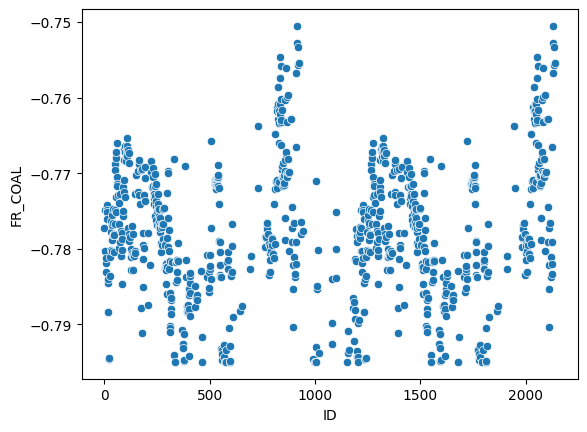

In [6]:
sns.scatterplot(x=df[df['FR_COAL'] < -0.75].index, y=df[df['FR_COAL'] < -0.75]['FR_COAL'])

<Axes: xlabel='ID', ylabel='DE_WIND'>

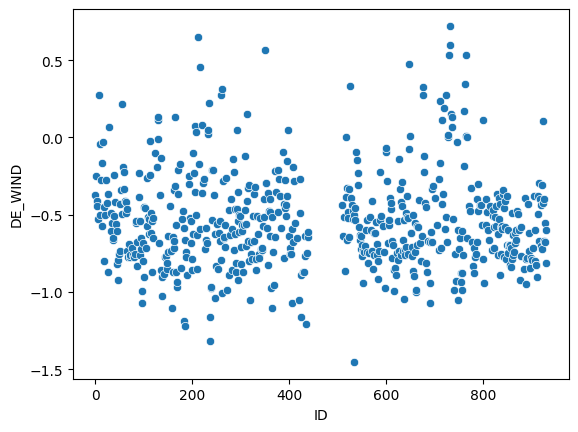

In [7]:
df_wind = de['DE_WIND'].copy()
left_mean = df_wind[df_wind.index < 450].mean()
left_std = df_wind[df_wind.index < 450].std()
df_wind[df_wind.index > 450] = (df_wind[df_wind.index > 450] - df_wind[df_wind.index > 450].mean()) / df_wind[df_wind.index > 450].std()
df_wind[df_wind.index > 450] = (df_wind[df_wind.index > 450] * left_std) + left_mean  
sns.scatterplot(x=df_wind.index, y=df_wind)

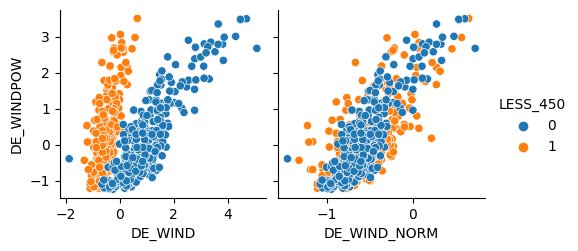

In [8]:
wind_norm = de[['DE_WIND', 'DE_WINDPOW']].copy()
wind_norm['DE_WIND_NORM'] = df_wind
wind_norm['LESS_450'] = 1
wind_norm.loc[wind_norm.index > 450, 'LESS_450'] = 0
sns.pairplot(data=wind_norm, x_vars=['DE_WIND', 'DE_WIND_NORM'], y_vars='DE_WINDPOW', hue='LESS_450')

<Axes: xlabel='ID', ylabel='FR_TEMP'>

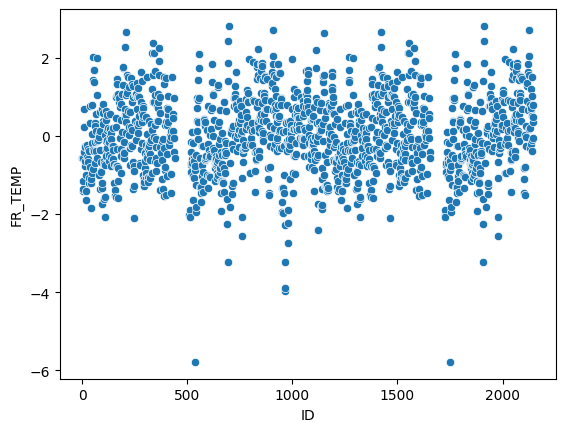

In [9]:
sns.scatterplot(x=df.index, y=df['FR_TEMP'])

<Axes: xlabel='ID', ylabel='DE_WIND'>

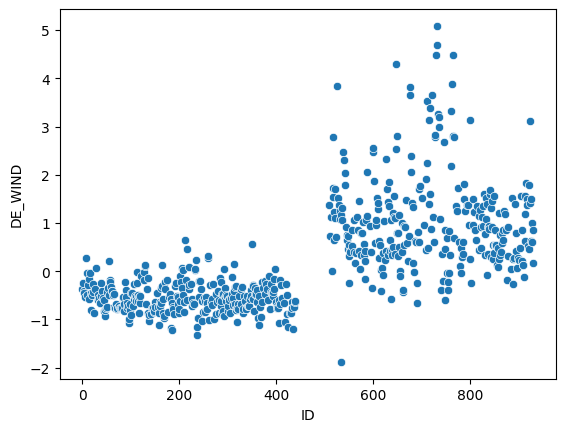

In [10]:
sns.scatterplot(x=de.index, y=de['DE_WIND'])

<Axes: xlabel='ID', ylabel='DE_WIND'>

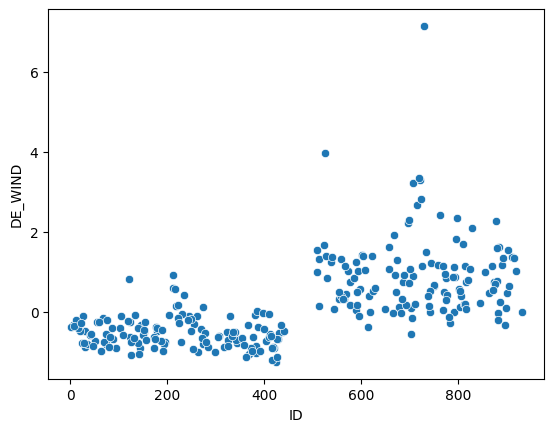

In [11]:
sns.scatterplot(x=true_test[true_test['COUNTRY'] == 'DE'].index, y=true_test[true_test['COUNTRY'] == 'DE']['DE_WIND'])

<Axes: xlabel='ID', ylabel='FR_GAS'>

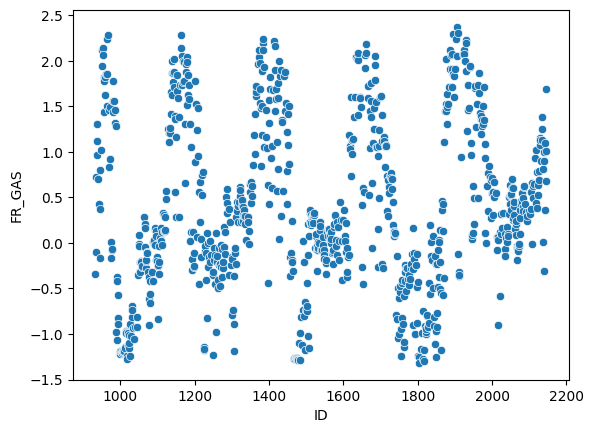

In [12]:
temp_fr = fr.copy()
temp_fr['TARGET'] = y_fr['TARGET']
sns.scatterplot(x=temp_fr.index, y=temp_fr['FR_GAS'])

<Axes: xlabel='ID', ylabel='DE_LIGNITE'>

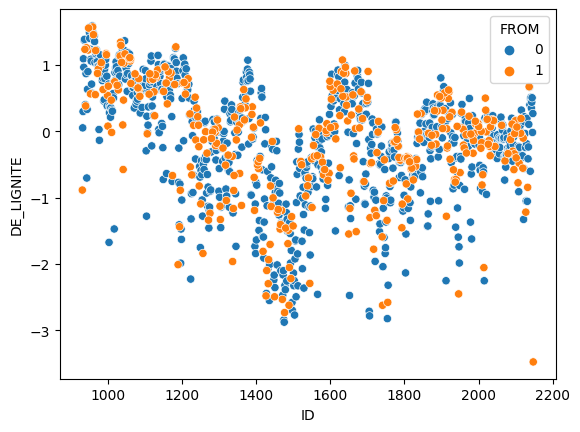

In [13]:
both_fr = fr.append(true_test.loc[true_test['COUNTRY'] == 'FR'])
both_fr['FROM'] = 0
both_fr.loc[true_test[true_test['COUNTRY'] == 'FR'].index, 'FROM'] = 1
sns.scatterplot(x=both_fr.index, y=both_fr['DE_LIGNITE'], hue=both_fr['FROM'])

[106.81647765176784, 182.18498999332888, 188.5212808539026, 458.64736490994]
[106.81647765176784, 188.5212808539026, 263.88979319546365, 458.64736490994]


<Figure size 640x480 with 0 Axes>

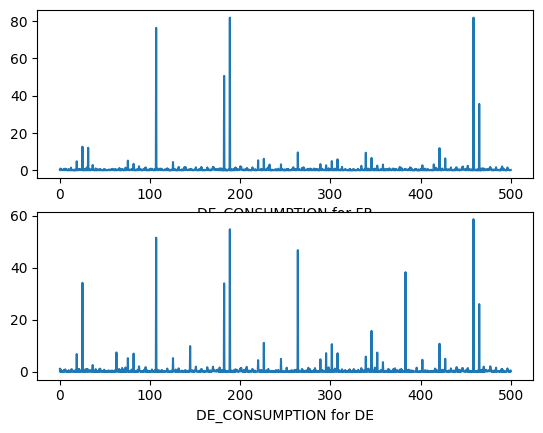

[182.18498999332888, 188.5212808539026, 458.64736490994, 464.9836557705137]
[25.11167444963309, 182.18498999332888, 188.5212808539026, 345.5945963975984, 458.64736490994, 464.9836557705137]


<Figure size 640x480 with 0 Axes>

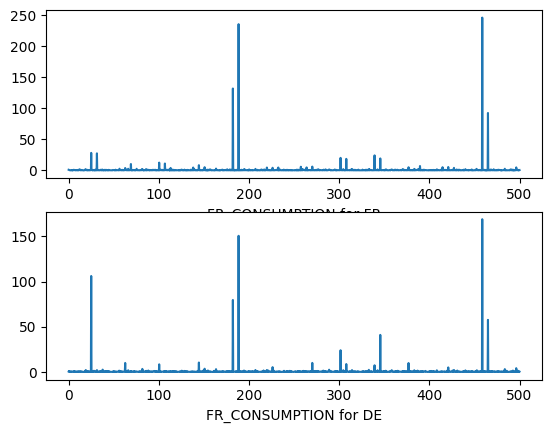

[182.18498999332888, 188.5212808539026, 263.88979319546365, 383.2788525683789, 458.64736490994, 464.9836557705137]
[106.81647765176784, 188.5212808539026, 263.88979319546365, 383.2788525683789, 458.64736490994]


<Figure size 640x480 with 0 Axes>

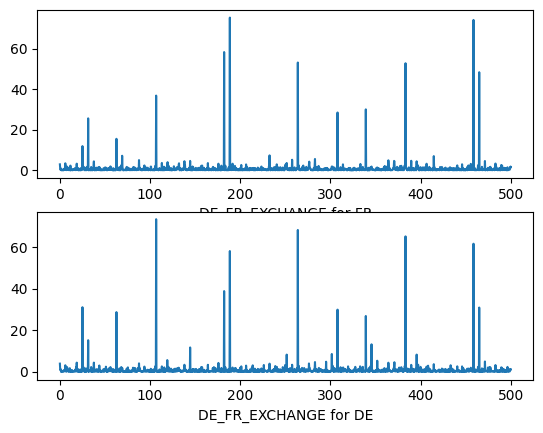

[182.18498999332888, 188.5212808539026, 263.88979319546365, 383.2788525683789, 458.64736490994, 464.9836557705137]
[106.81647765176784, 188.5212808539026, 263.88979319546365, 383.2788525683789, 458.64736490994]


<Figure size 640x480 with 0 Axes>

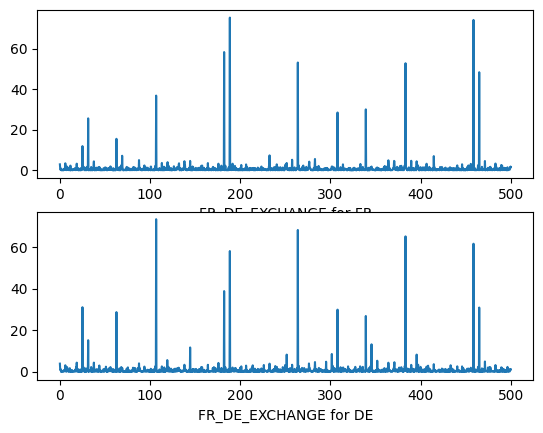

[25.11167444963309, 182.18498999332888, 188.5212808539026, 458.64736490994]
[25.11167444963309, 188.5212808539026, 458.64736490994]


<Figure size 640x480 with 0 Axes>

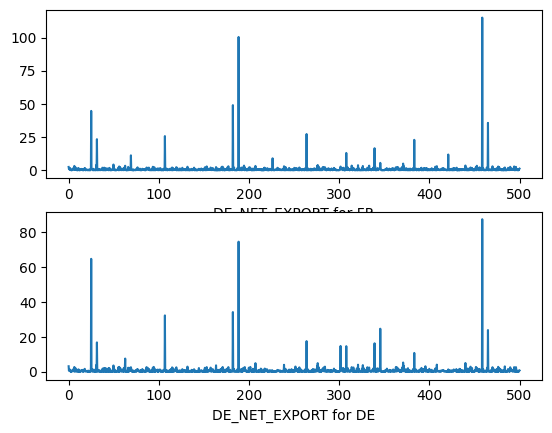

[62.79593062041361, 106.81647765176784, 144.50073382254837, 226.2055370246831, 263.88979319546365, 307.9103402268179, 339.2583055370247, 383.2788525683789, 420.96310873915945]
[62.79593062041361, 106.81647765176784, 144.50073382254837, 226.2055370246831, 263.88979319546365, 307.9103402268179, 339.2583055370247, 383.2788525683789, 420.96310873915945]


<Figure size 640x480 with 0 Axes>

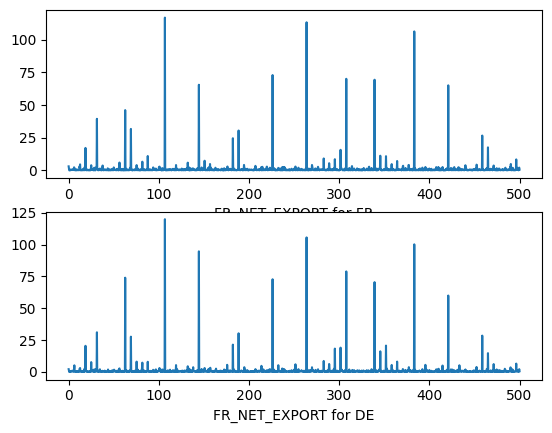

[25.11167444963309, 182.18498999332888, 188.5212808539026, 458.64736490994]
[25.11167444963309, 188.5212808539026, 458.64736490994]


<Figure size 640x480 with 0 Axes>

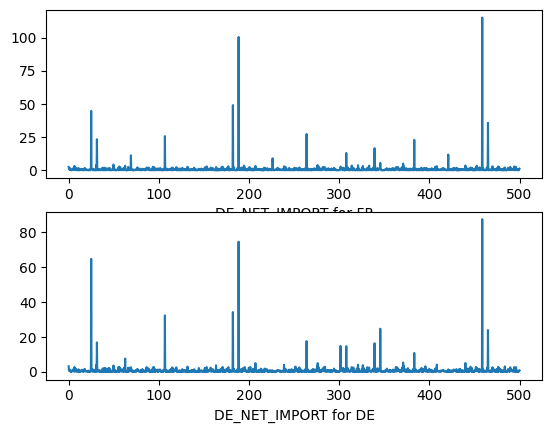

[62.79593062041361, 106.81647765176784, 144.50073382254837, 226.2055370246831, 263.88979319546365, 307.9103402268179, 339.2583055370247, 383.2788525683789, 420.96310873915945]
[62.79593062041361, 106.81647765176784, 144.50073382254837, 226.2055370246831, 263.88979319546365, 307.9103402268179, 339.2583055370247, 383.2788525683789, 420.96310873915945]


<Figure size 640x480 with 0 Axes>

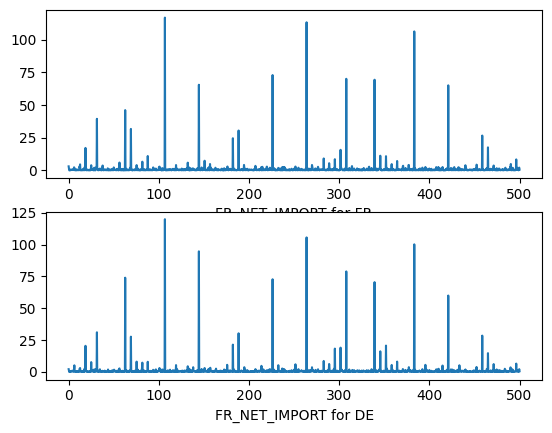

[106.81647765176784, 263.88979319546365, 339.2583055370247, 383.2788525683789]
[106.81647765176784, 263.88979319546365, 383.2788525683789]


<Figure size 640x480 with 0 Axes>

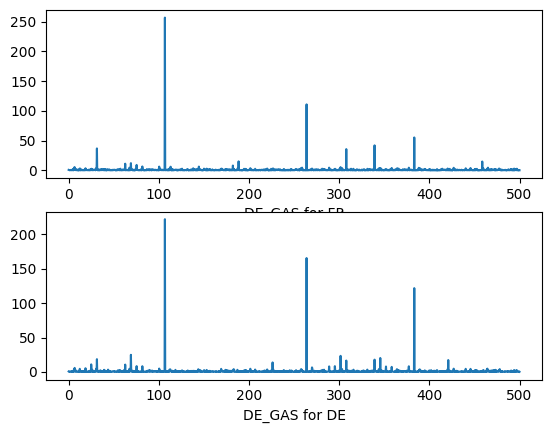

[106.81647765176784, 182.18498999332888, 188.5212808539026, 458.64736490994, 464.9836557705137]
[25.11167444963309, 106.81647765176784, 182.18498999332888, 188.5212808539026, 301.5740493662442, 345.5945963975984, 458.64736490994]


<Figure size 640x480 with 0 Axes>

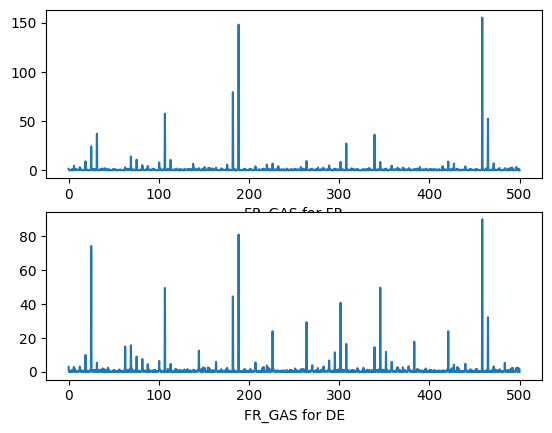

[188.5212808539026, 263.88979319546365, 383.2788525683789, 458.64736490994]
[106.81647765176784, 188.5212808539026, 263.88979319546365, 383.2788525683789, 458.64736490994]


<Figure size 640x480 with 0 Axes>

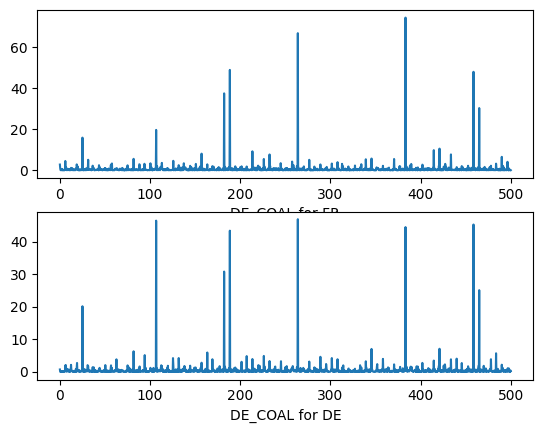

[106.81647765176784]
[106.81647765176784]


<Figure size 640x480 with 0 Axes>

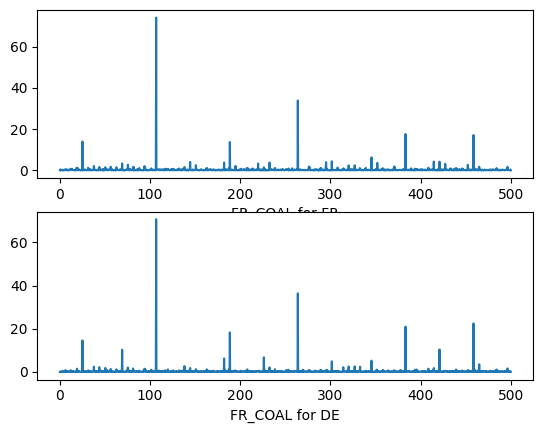

[106.81647765176784, 182.18498999332888, 188.5212808539026, 263.88979319546365, 383.2788525683789, 458.64736490994, 464.9836557705137]
[25.11167444963309, 106.81647765176784, 182.18498999332888, 188.5212808539026, 263.88979319546365, 383.2788525683789, 458.64736490994, 464.9836557705137]


<Figure size 640x480 with 0 Axes>

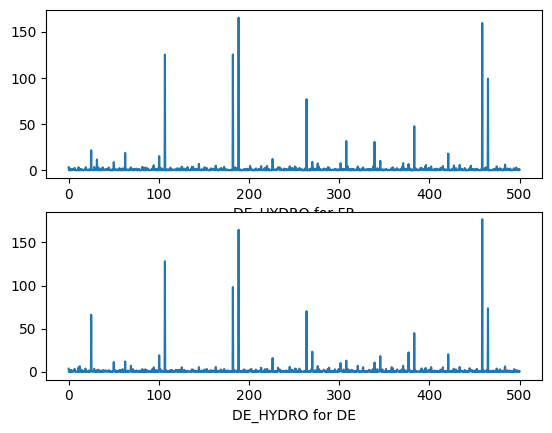

[106.81647765176784, 182.18498999332888, 188.5212808539026, 263.88979319546365, 383.2788525683789, 458.64736490994, 464.9836557705137]
[25.11167444963309, 106.81647765176784, 188.5212808539026, 263.88979319546365, 383.2788525683789, 458.64736490994]


<Figure size 640x480 with 0 Axes>

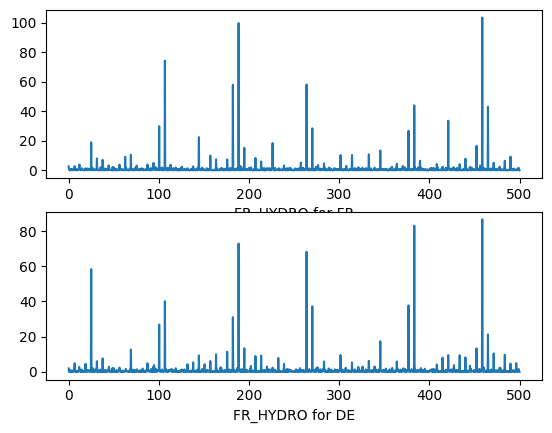

[106.81647765176784, 144.50073382254837, 226.2055370246831, 263.88979319546365, 383.2788525683789, 420.96310873915945]
[106.81647765176784, 144.50073382254837, 226.2055370246831, 263.88979319546365, 383.2788525683789, 420.96310873915945]


<Figure size 640x480 with 0 Axes>

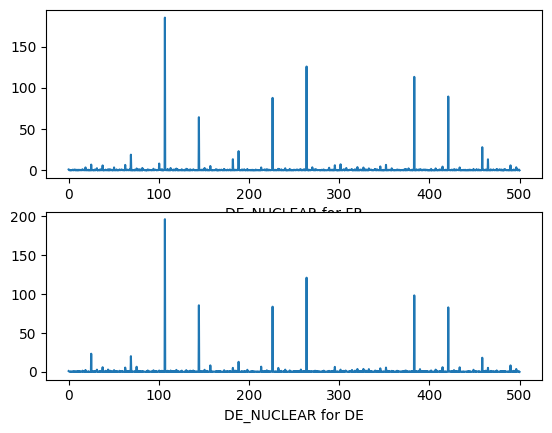

[106.81647765176784, 144.50073382254837, 182.18498999332888, 188.5212808539026, 226.2055370246831, 263.88979319546365, 383.2788525683789, 420.96310873915945, 458.64736490994, 464.9836557705137]
[25.11167444963309, 106.81647765176784, 144.50073382254837, 182.18498999332888, 188.5212808539026, 226.2055370246831, 263.88979319546365, 383.2788525683789, 420.96310873915945, 458.64736490994]


<Figure size 640x480 with 0 Axes>

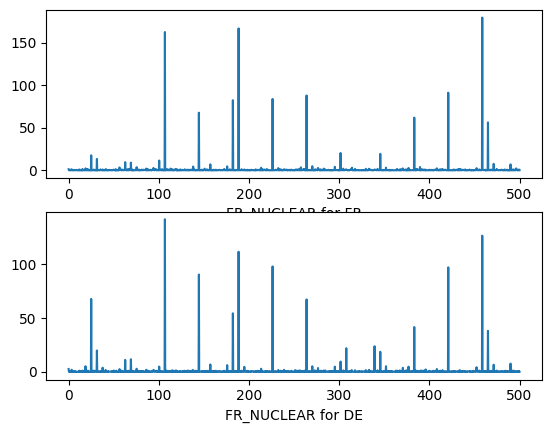

[25.11167444963309, 182.18498999332888, 188.5212808539026, 458.64736490994, 464.9836557705137]
[25.11167444963309, 182.18498999332888, 188.5212808539026, 458.64736490994, 464.9836557705137]


<Figure size 640x480 with 0 Axes>

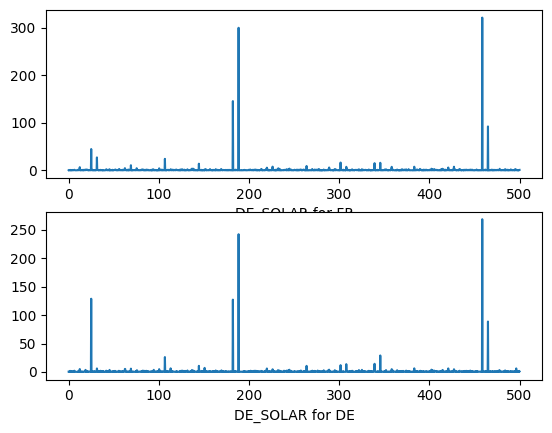

[25.11167444963309, 106.81647765176784, 182.18498999332888, 188.5212808539026, 263.88979319546365, 458.64736490994, 464.9836557705137]
[25.11167444963309, 106.81647765176784, 182.18498999332888, 188.5212808539026, 263.88979319546365, 383.2788525683789, 458.64736490994, 464.9836557705137]


<Figure size 640x480 with 0 Axes>

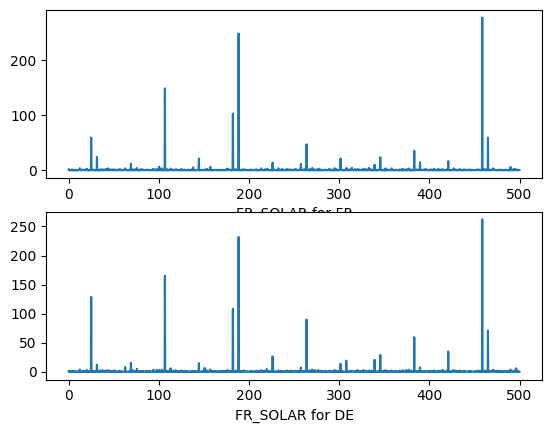

[182.18498999332888, 188.5212808539026, 458.64736490994]
[182.18498999332888, 188.5212808539026, 458.64736490994]


<Figure size 640x480 with 0 Axes>

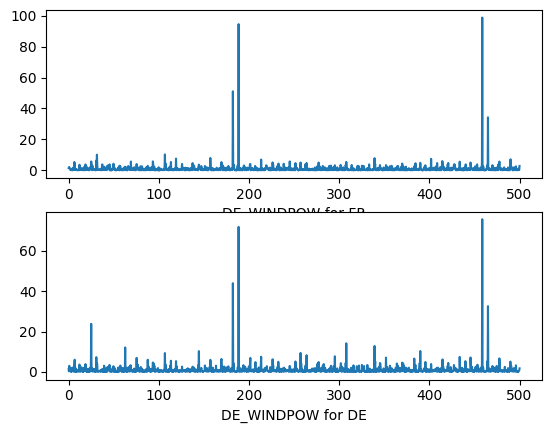

[106.81647765176784, 182.18498999332888, 188.5212808539026, 458.64736490994, 464.9836557705137]
[106.81647765176784, 182.18498999332888, 188.5212808539026, 263.88979319546365, 458.64736490994, 464.9836557705137]


<Figure size 640x480 with 0 Axes>

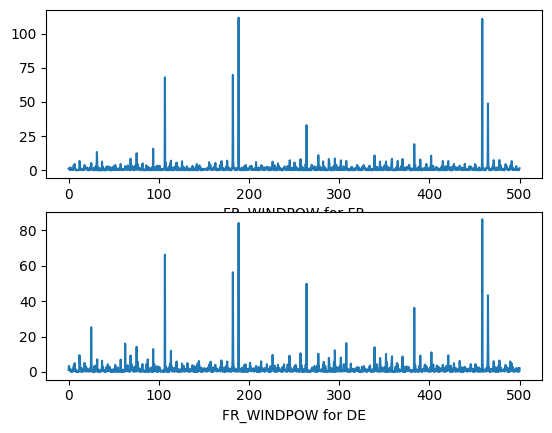

[106.81647765176784, 263.88979319546365, 383.2788525683789]
[106.81647765176784, 263.88979319546365, 383.2788525683789]


<Figure size 640x480 with 0 Axes>

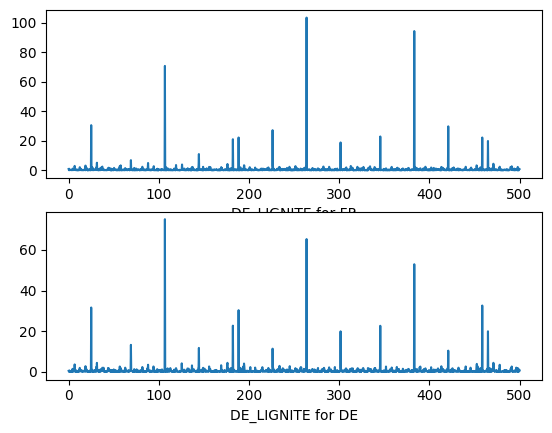

[]
[]


<Figure size 640x480 with 0 Axes>

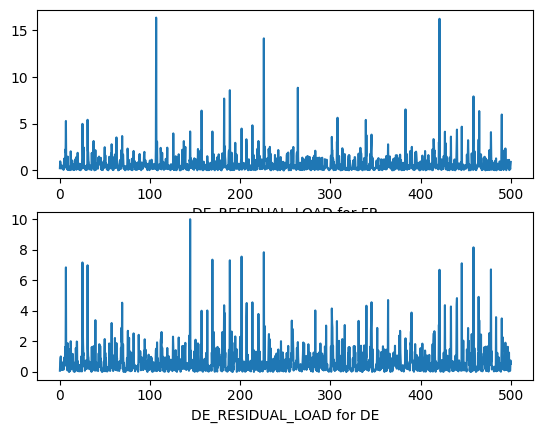

[182.18498999332888, 188.5212808539026, 458.64736490994, 464.9836557705137]
[25.11167444963309, 182.18498999332888, 188.5212808539026, 458.64736490994, 464.9836557705137]


<Figure size 640x480 with 0 Axes>

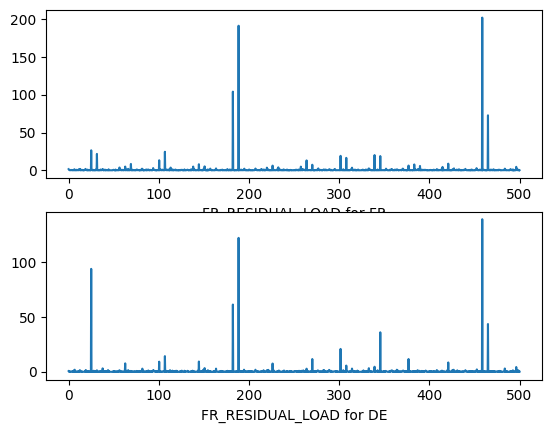

[]
[]


<Figure size 640x480 with 0 Axes>

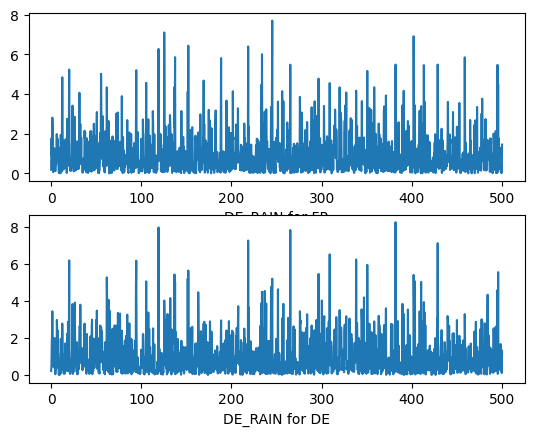

[]
[]


<Figure size 640x480 with 0 Axes>

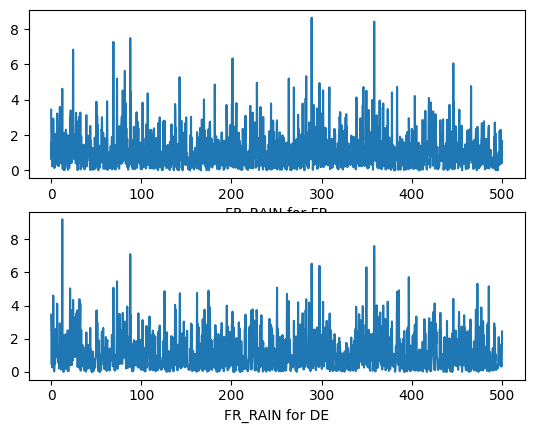

[106.81647765176784, 226.2055370246831, 263.88979319546365, 383.2788525683789, 420.96310873915945]
[106.81647765176784, 263.88979319546365, 383.2788525683789]


<Figure size 640x480 with 0 Axes>

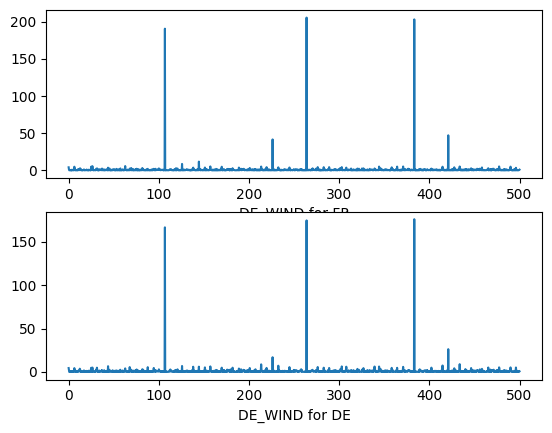

[106.81647765176784, 263.88979319546365, 383.2788525683789]
[106.81647765176784, 263.88979319546365, 383.2788525683789]


<Figure size 640x480 with 0 Axes>

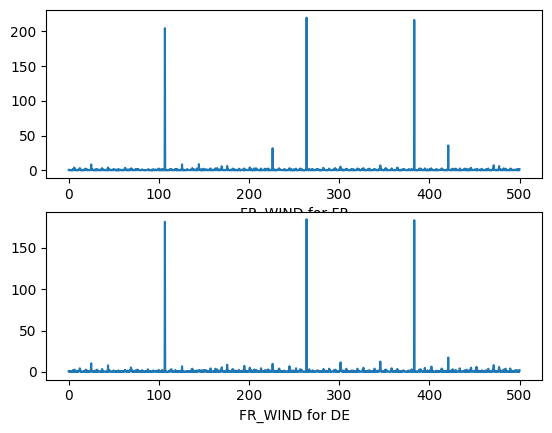

[]
[]


<Figure size 640x480 with 0 Axes>

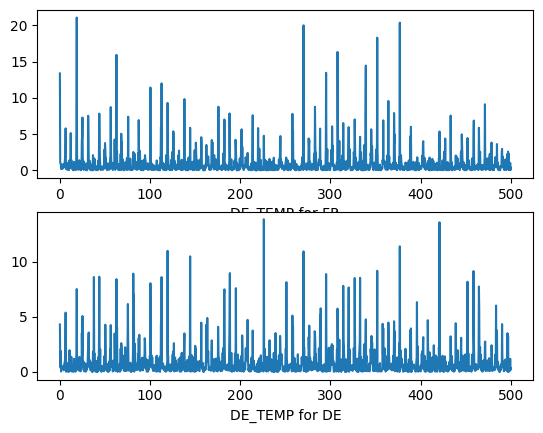

[]
[]


<Figure size 640x480 with 0 Axes>

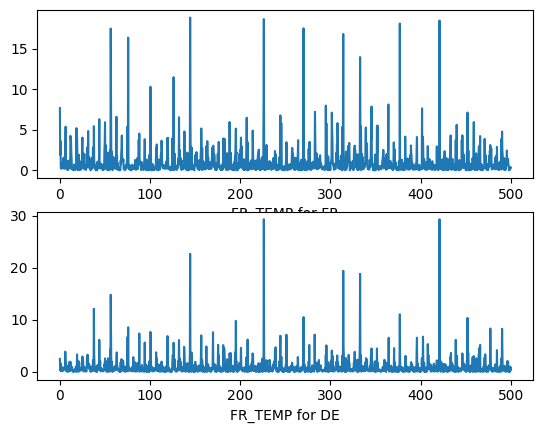

[]
[]


<Figure size 640x480 with 0 Axes>

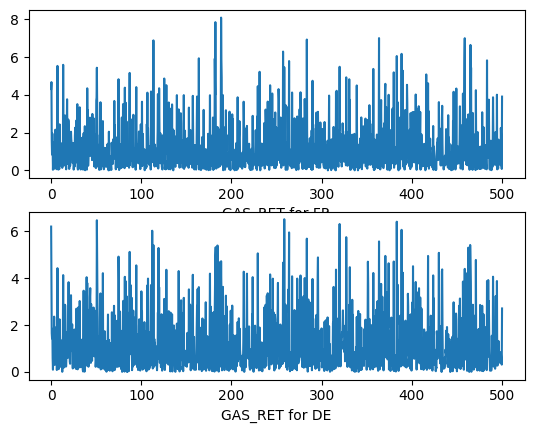

[]
[]


<Figure size 640x480 with 0 Axes>

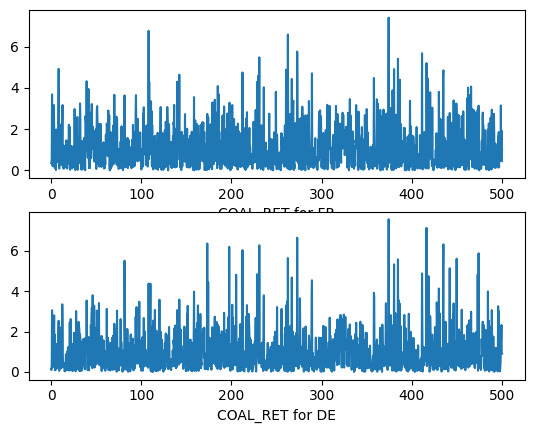

[]
[]


<Figure size 640x480 with 0 Axes>

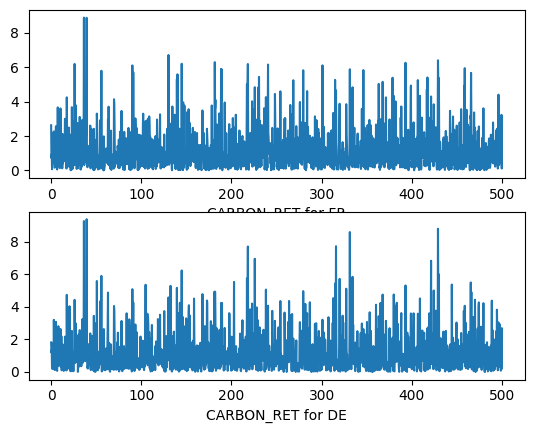

In [39]:
fs = np.linspace(0.1, 500, 1500)
for col in fr.drop(['DAY_ID', 'COUNTRY'], axis=1).columns:
    plt.figure()
    fig, axs = plt.subplots(2)
    
    pgram = signal.lombscargle(x=fr[col].dropna().index, y=fr[col].dropna(), freqs=fs)
    print([fs[i] for i in np.argwhere(pgram > 40).ravel()])
    p_fr = sns.lineplot(x=fs, y=pgram, ax=axs[0])
    p_fr.set(xlabel=f'{col} for FR')
    
    pgram = signal.lombscargle(x=de[col].dropna().index, y=de[col].dropna(), freqs=fs)
    print([fs[i] for i in np.argwhere(pgram > 40).ravel()])
    p_de = sns.lineplot(x=fs, y=pgram, ax=axs[1])
    p_de.set(xlabel=f'{col} for DE')
    
    plt.show()

In [15]:
fourier_features(fuel_cost(enum_country(make_wind_sqcb(country_flow((basic_clean(df)))))))

COUNTRY    DE_GAS    FR_GAS   DE_COAL   FR_COAL  DE_HYDRO  FR_HYDRO  \
ID                                                                          
0           0  0.836731  0.048137  0.200623 -0.777195  0.076310 -0.664384   
2           0  1.062806 -0.149029  0.292958 -0.433503 -0.487960 -0.651284   
3           0  1.223117  0.751191  0.150620 -0.780338  0.044238 -0.780774   
4           0  0.202693  0.529175 -0.665840 -0.774925 -0.738709 -0.634913   
5           0  0.637224  0.780458 -0.746381 -0.780286 -0.014076 -0.507558   
...       ...       ...       ...       ...       ...       ...       ...   
2142        1  0.533996  1.097201  0.568480 -0.216372 -0.473725 -0.883788   
2143        1  0.442421  0.367265  0.785531 -0.234862 -1.121350 -0.696835   
2144        1  0.796232  0.675199  0.865687 -0.222342 -0.355897 -0.714343   
2145        1  1.054524  1.009240  1.554055 -0.265893 -0.850534 -1.001921   
2146        1  2.078297  1.688479  1.411068  0.591205  0.030002 -0.507002   

      DE_NUCLEAR  FR_NUCLEAR  DE_SOLAR  FR_SOLAR  DE_WINDPOW  FR_WINDPOW  \
ID                                                                         
0       0.780177    0.661807  0.390828  0.598856   -0.012385   -0.970238   
2       0.832773    0.487943  0.447086  0.374206   -0.329384    0.763672   
3       0.842046    0.325375 -0.053067  1.317438   -0.446433    0.313770   
4       0.126256    0.179647  1.431625  0.746898    0.465544    0.673174   
5       0.131863    0.297371  1.377499  0.117900    0.639742   -0.407567   
...          ...         ...       ...       ...         ...         ...   
2142   -1.914119   -1.489547 -1.120453 -0.213344    1.023247    3.298833   
2143   -1.919768   -1.418159 -0.636313 -0.304667    0.811159    2.862619   
2144   -1.928200   -1.331032 -1.029400 -0.211453    0.292369    2.213918   
2145   -1.928367   -1.301150 -0.955153 -0.208504    0.105193    0.351713   
2146   -2.001415   -1.330165 -1.239191 -0.653159    0.321488    0.190965   

      DE_LIGNITE  DE_RESIDUAL_LOAD  FR_RESIDUAL_LOAD   DE_RAIN   FR_RAIN  \
ID                                                                         
0       0.625910          0.293219          0.448995 -0.047033 -0.248052   
2       0.722983          0.529501          0.151134 -0.274901 -0.347173   
3       0.707787          0.738900          0.187547 -0.672022 -0.421214   
4       0.500184         -0.656051          0.158859 -0.300883 -0.148592   
5       0.247893         -0.613143          0.335134 -0.347601  0.035837   
...          ...               ...               ...       ...       ...   
2142    0.347272          0.163624         -0.322860 -0.042241  0.517631   
2143    0.436883          0.160769         -0.265981  0.086420  0.643169   
2144    0.503896          0.760865         -0.230426  0.213069 -0.442086   
2145   -0.018965          0.736311          0.090669  0.045473 -0.285825   
2146    0.266504          0.857835          0.272440  0.321287  1.692881   

       DE_TEMP   FR_TEMP   GAS_RET  COAL_RET  CARBON_RET  EXCHANGE  \
ID                                                                   
0    -0.466573 -0.558732  1.602466  1.527066    1.790950  0.778353   
2    -1.817422 -1.163299  1.596267  1.409234    0.593396 -0.179177   
3    -2.170678 -1.399423  0.172622 -0.847545   -0.313360 -0.707035   
4    -0.795390 -1.352885 -1.951199  0.273857   -1.847703  0.389806   
5    -0.511760 -0.562027 -0.307876  0.225957   -0.408372  0.226737   
...        ...       ...       ...       ...         ...       ...   
2142 -1.225979 -0.113555  0.785530 -0.322581    0.362803 -0.451691   
2143 -0.107380 -0.046727  0.961630  0.891689    1.012246 -1.138619   
2144  0.047149  0.364089 -0.784590  1.046452   -0.545607  0.093751   
2145  0.340100  0.481030  0.149340  0.251444    0.541685 -1.215111   
2146  0.242526  0.785115  0.926260 -0.021154   -0.144349 -2.294389   

      SELF_EXPORT  OTHER_EXPORT  SELF_CONSUMPTION  OTHER_CONSUMPTION  \
ID                                         

<Figure size 640x480 with 0 Axes>

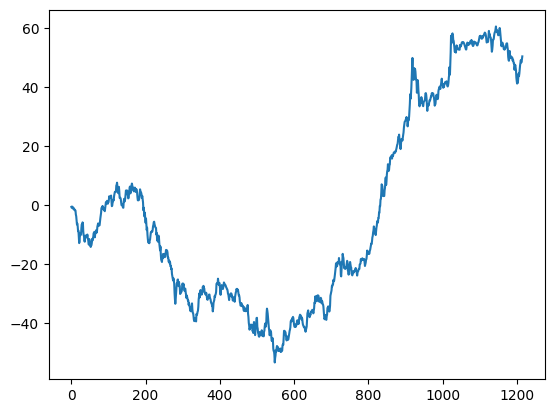

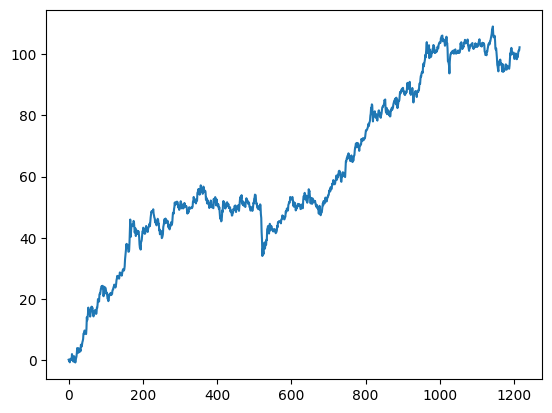

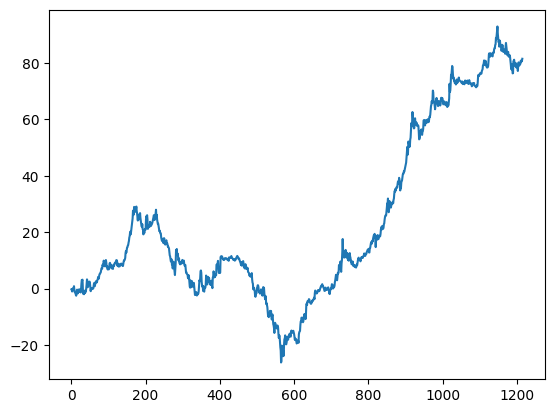

In [16]:
temp = fr[['GAS_RET', 'COAL_RET', 'CARBON_RET']].copy()
temp = temp.append(true_test.loc[true_test['COUNTRY'] == 'FR', ['GAS_RET', 'COAL_RET', 'CARBON_RET']]).sort_index()
gas = [0]
coal = [0]
carbon = [0]
prices = [gas, coal, carbon]
for row in temp.itertuples(index=False):
    for i in range(3):
        prices[i].append(prices[i][-1] + row[i])
for i in range(3):
    prices[i].pop(0)
plt.clf()
for p in prices:
    plt.figure()
    sns.lineplot(x=range(len(p)), y=p)

<Axes: xlabel='ID'>

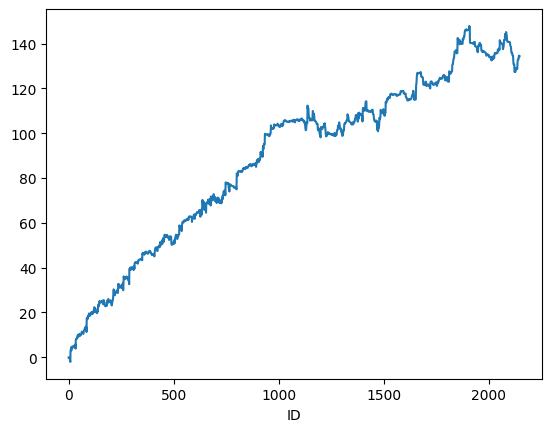

In [17]:
energy = [0]
for row in y.itertuples(index=False):
    energy.append(energy[-1] + row[0])
energy.pop(0)
sns.lineplot(x=y.index, y=energy)

### Benchmarking
Running linear regression on the same train test split for a basic performance benchmark. For now we just replace NaN values with 0.

In [18]:
br_lr = LinearRegression()

br_x_train_clean, br_x_test_clean = bx_train.fillna(0).drop(['DAY_ID', 'COUNTRY'], axis=1), bx_test.fillna(0).drop(['DAY_ID', 'COUNTRY'], axis=1)
y_train_clean, y_test_clean = by_train['TARGET'], by_test['TARGET']

test_model(br_lr, br_x_train_clean, br_x_test_clean, y_train_clean, y_test_clean)

fit on test set: 23.6%
fit on training set: 26.8%



(array([ 7.29265737e-02,  3.50514120e-01,  6.63566499e-02,  1.14325006e-01,
         2.87391736e-01,  2.25479587e-01, -9.24319396e-03, -9.48980331e-02,
        -1.58381788e-01,  2.84951181e-01, -2.95344317e-01,  3.57920820e-01,
        -1.13317100e-01,  1.59812050e-01,  2.50583784e-01, -5.56315631e-01,
        -2.45102069e-01, -1.22478802e-01,  2.97163443e-01,  4.63360292e-01,
         8.66189715e-02,  3.77441423e-01,  8.65506543e-01,  6.14460480e-03,
         1.42907486e-01, -2.70748564e-02, -6.91611216e-02,  2.50767002e-01,
        -1.05310439e-01, -6.34790026e-02,  1.99599850e-01,  2.25203934e-01,
         1.39097012e-01,  2.30811355e-01,  1.01828152e-01,  1.82469160e-02,
         5.05333486e-01,  1.18744375e-01,  1.92085497e-01,  2.50583784e-01,
         9.19680718e-02,  9.92185036e-02,  3.99156483e-01,  2.75968304e-01,
         1.21283006e-01,  5.40762624e-01, -1.39931504e-01, -2.16358126e-01,
         1.80743659e-01,  4.22247024e-02,  8.97494133e-02, -4.05986349e-02,
         1.0

### Feature Engineering

In [19]:
km = KMeans(n_clusters=2)
km.fit(df_numeric)
km.labels_
df_clustered = df_numeric.copy()
df_clustered['CLUSTER'] = km.labels_
# sns.pairplot(data=df_clustered, vars=['DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'DE_NET_IMPORT',
#       'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO',
#       'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR',
#       'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD',
#       'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND', 'FR_WIND',
#       'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET'], hue='CLUSTER')

In [20]:
y

TARGET
ID            
0    -0.163530
2     0.010774
3    -0.233505
4     0.029822
5    -0.073464
...        ...
2142  0.957628
2143  0.687808
2144 -0.083983
2145 -0.176865
2146 -0.020303

[1494 rows x 1 columns]

### Models

Trying various models.

TODO read through and implement stuff from here, paper notes that drivers of electricity prices are nonlinear: https://www.sciencedirect.com/science/article/pii/S0301421518307432

In [21]:
x_fr = fuel_cost(make_wind_sqcb(country_flow((basic_clean(fr)))).drop('COUNTRY', axis=1))
x_de = fuel_cost(make_wind_sqcb(country_flow((basic_clean(de)))).drop('COUNTRY', axis=1))

In [84]:
x = fourier_features(fuel_cost(enum_country(make_wind_sqcb(country_flow((basic_clean(fr))))))) \
#    .drop(['DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO', 'FR_HYDRO',
 #      'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR', 'GAS_RET', 'COAL_RET', 'DE_RAIN', 'FR_RAIN', 'DE_LIGNITE'], axis=1)
target = y
# x = x_fr
target = y_fr
# de: ridge alpha 40, xgb gamma 25

In [74]:
x.columns

Index(['COUNTRY', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO',
       'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR',
       'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD',
       'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_TEMP', 'FR_TEMP',
       'GAS_RET', 'COAL_RET', 'CARBON_RET', 'EXCHANGE', 'SELF_EXPORT',
       'OTHER_EXPORT', 'SELF_CONSUMPTION', 'OTHER_CONSUMPTION', 'DE_WIND_SQCB',
       'FR_WIND_SQCB', 'DE_GAS_COST', 'DE_GAS_CARBON', 'DE_COAL_COST',
       'DE_COAL_CARBON', 'FR_GAS_COST', 'FR_GAS_CARBON', 'FR_COAL_COST',
       'FR_COAL_CARBON', 'DE_LIGNITE_CARBON', 'SIN_365_1', 'COS365_1',
       'SIN_365_2', 'COS365_2', 'SIN_365_3', 'COS365_3',
       'SIN_106.81647765176784_1', 'COS106.81647765176784_1',
       'SIN_106.81647765176784_2', 'COS106.81647765176784_2',
       'SIN_106.81647765176784_3', 'COS106.81647765176784_3', 'TIME'],
      dtype='object')

In [75]:
#########################################################################################################
# x_train, x_test, y_train, y_test = x, df_test, y['TARGET'], None
#########################################################################################################

In [76]:
# perform train test split after features have been calculated
x_train, x_test, y_train, y_test = train_test_split(x, target['TARGET'], test_size=0.33, random_state=88, shuffle=False)

In [77]:
x_train = make_wind_excess(x, x_train.index, drop_windpow=False, use_iloc=False).loc[x_train.index]
x_test = make_wind_excess(x, x_train.index, drop_windpow=False, use_iloc=False).loc[x_test.index]

In [78]:
x_train.columns

Index(['COUNTRY', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO',
       'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR',
       'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD',
       'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_TEMP', 'FR_TEMP',
       'GAS_RET', 'COAL_RET', 'CARBON_RET', 'EXCHANGE', 'SELF_EXPORT',
       'OTHER_EXPORT', 'SELF_CONSUMPTION', 'OTHER_CONSUMPTION', 'DE_WIND_SQCB',
       'FR_WIND_SQCB', 'DE_GAS_COST', 'DE_GAS_CARBON', 'DE_COAL_COST',
       'DE_COAL_CARBON', 'FR_GAS_COST', 'FR_GAS_CARBON', 'FR_COAL_COST',
       'FR_COAL_CARBON', 'DE_LIGNITE_CARBON', 'SIN_365_1', 'COS365_1',
       'SIN_365_2', 'COS365_2', 'SIN_365_3', 'COS365_3',
       'SIN_106.81647765176784_1', 'COS106.81647765176784_1',
       'SIN_106.81647765176784_2', 'COS106.81647765176784_2',
       'SIN_106.81647765176784_3', 'COS106.81647765176784_3', 'TIME',
       'DE_WIND_EXCESS', 'FR_WIND_EXCESS'],
      dtype='object')

#### Baseline Linear Regression

In [79]:
lr = LinearRegression()
train_result, test_result = test_model(lr, x_train, x_test, y_train, y_test)

fit on test set: -3.1%
fit on training set: 23.2%



#### Ridge Regression

fit on test set: -1.1%
fit on training set: 23.1%



<Figure size 640x480 with 0 Axes>

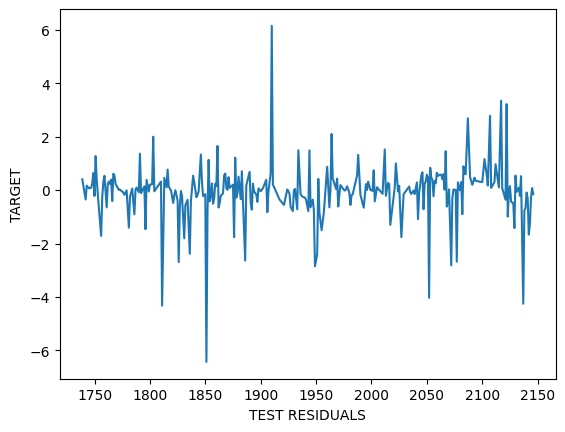

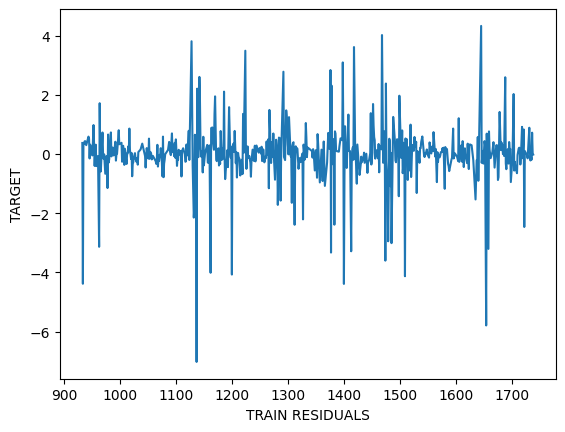

In [80]:
ridge = linear_model.Ridge(alpha=40)
train_result, test_result = test_model(ridge, x_train, x_test, y_train, y_test, print_output=False, graph_residuals=True)

#### XGB Regression

In [81]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=25)
train_result, test_result = test_model(xgb_model, x_train, x_test, y_train, y_test, print_output=False, graph_residuals=False)

fit on test set: nan%
fit on training set: nan%



In [82]:
kf = KFold(n_splits = 10, shuffle=True)
kf_test_model(kf, xgb_model, x, target)

fit on test set: 13.9%
fit on training set: 11.1%

fit on test set: -16.9%
fit on training set: 12.9%

fit on test set: nan%
fit on training set: nan%

fit on test set: 4.8%
fit on training set: 18.6%

fit on test set: 7.1%
fit on training set: 20.7%

fit on test set: 6.9%
fit on training set: 9.2%

fit on test set: -25.1%
fit on training set: 9.0%

fit on test set: nan%
fit on training set: nan%

fit on test set: -0.8%
fit on training set: 19.8%

fit on test set: -2.1%
fit on training set: 23.0%



#### Ridge Regression - XGB Hybrid

model_0 fit on test set: -1.1%
model_0 fit on train set: 23.1%
model_1 fit on test residuals: nan%
model_1 fit on train residuals: nan%
fit on test set: -1.1%
fit on training set: 23.1%



<Figure size 640x480 with 0 Axes>

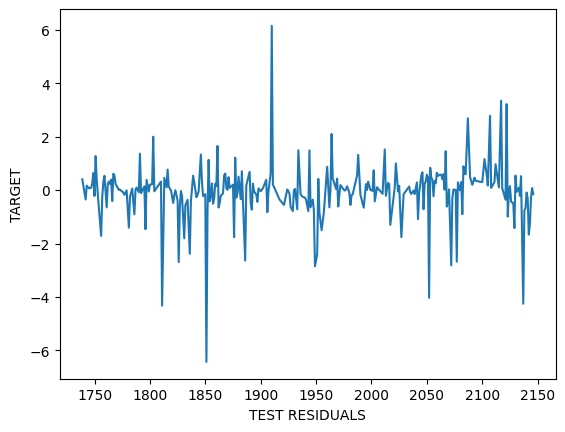

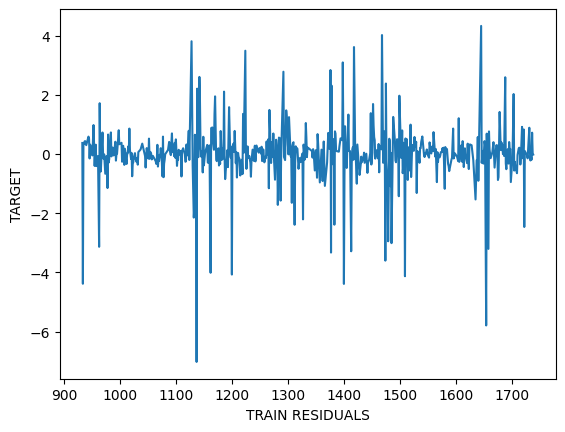

In [83]:
ridge = linear_model.Ridge(alpha=40)
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=25)
train_result, test_result = test_model(ridge, x_train, x_test, y_train, y_test, model_1=xgb_model, detailed=True, print_output=False, graph_residuals=True)

#### MLP Regressor

In [33]:
mlpr = MLPRegressor(alpha=0.01, solver='lbfgs', hidden_layer_sizes=(50, 20))
train_result, test_result = test_model(mlpr, x_train, x_test, y_train, y_test)

fit on test set: 27.4%
fit on training set: 31.5%



#### MLP Regressor - XGB Hybrid

In [34]:
x_train_lag = x_train.copy()
x_test_lag = x_test.copy()

In [35]:
x_train_lag

COUNTRY    DE_GAS    FR_GAS   DE_COAL   FR_COAL  DE_HYDRO  FR_HYDRO  \
ID                                                                         
0          0  0.836731  0.048137  0.200623 -0.777195  0.076310 -0.664384   
2          0  1.062806 -0.149029  0.292958 -0.433503 -0.487960 -0.651284   
3          0  1.223117  0.751191  0.150620 -0.780338  0.044238 -0.780774   
4          0  0.202693  0.529175 -0.665840 -0.774925 -0.738709 -0.634913   
5          0  0.637224  0.780458 -0.746381 -0.780286 -0.014076 -0.507558   
..       ...       ...       ...       ...       ...       ...       ...   
616        0  0.318171 -0.561521  0.845831  0.159960  0.401666 -0.382616   
618        0  0.532865  0.201683  1.110380  0.156575  0.792882 -0.000980   
620        0  0.359571  0.011282  0.850067 -0.259890  0.855484 -0.196939   
621        0  0.493432 -0.141655  0.757431 -0.302000  0.939010 -0.333541   
623        0  0.300142 -0.189431  0.987852 -0.296471 -0.068616  0.101351   

     DE_NUCLEAR  FR_NUCLEAR  DE_SOLAR  FR_SOLAR  DE_WINDPOW  FR_WINDPOW  \
ID                                                                        
0      0.780177    0.661807  0.390828  0.598856   -0.012385   -0.970238   
2      0.832773    0.487943  0.447086  0.374206   -0.329384    0.763672   
3      0.842046    0.325375 -0.053067  1.317438   -0.446433    0.313770   
4      0.126256    0.179647  1.431625  0.746898    0.465544    0.673174   
5      0.131863    0.297371  1.377499  0.117900    0.639742   -0.407567   
..          ...         ...       ...       ...         ...         ...   
616    0.085297   -0.006817  1.573507  1.078755   -0.805376    0.169988   
618    0.067185   -0.236755  0.697410  0.565990   -0.972968   -0.514431   
620    0.086623   -0.298743  1.086400  0.187415   -0.845614   -0.286470   
621    0.074489   -0.245237 -0.561916  0.187137   -0.339909   -0.634773   
623    0.111392   -0.351241 -0.127426  1.350193   -0.674626   -0.983845   

     DE_LIGNITE  DE_RESIDUAL_LOAD  FR_RESIDUAL_LOAD   DE_RAIN   FR_RAIN  \
ID                                                                        
0      0.625910          0.293219          0.448995 -0.047033 -0.248052   
2      0.722983          0.529501          0.151134 -0.274901 -0.347173   
3      0.707787          0.738900          0.187547 -0.672022 -0.421214   
4      0.500184         -0.656051          0.158859 -0.300883 -0.148592   
5      0.247893         -0.613143          0.335134 -0.347601  0.035837   
..          ...               ...               ...       ...       ...   
616   -0.439994          0.324543         -0.682633 -0.755972 -0.427254   
618   -0.183667          0.686890         -0.619215  2.383630  0.798208   
620   -0.090886          0.489008         -0.551071 -1.079532  0.733366   
621   -0.013780          0.725023         -0.479741  1.875660  3.454977   
623   -0.109437          0.665888         -0.604460 -0.507831 -0.408094   

      DE_TEMP   FR_TEMP   GAS_RET  COAL_RET  CARBON_RET  EXCHANGE  \
ID                                                                  
0   -0.466573 -0.558732  1.602466  1.527066    1.790950  0.778353   
2   -1.817422 -1.163299  1.596267  1.409234    0.593396 -0.179177   
3   -2.170678 -1.399423  0.172622 -0.847545   -0.313360 -0.707035   
4   -0.795390 -1.352885 -1.951199  0.273857   -1.847703  0.389806   
5   -0.511760 -0.562027 -0.307876  0.225957   -0.408372  0.226737   
..        ...       ...       ...       ...         ...       ...   
616  0.517219  1.850339  0.162089  0.304237    0.699313 -0.272363   
618  1.100208  0.713570  0.338003 -1.207689    0.644785 -0.577114   
620  0.100325  1.086088 -0.609778 -0.836291    1.956549 -0.283818   
621  0.496315  1.038397 -0.309432  0.007263    2.016201 -0.373744   
623 -0.300132  0.008970  1.430121  0.136815    0.790496 -0.069797   

     SELF_EXPORT  OTHER_EXPORT  SELF_CONSUMPTION  OTHER_CONSUMPTION  \
ID                                                                    
0       0.931374     -0.

model_0 fit on test set: 35.3%
model_0 fit on train set: 34.2%
model_1 fit on test residuals: nan%
model_1 fit on train residuals: 14.5%
fit on test set: 35.3%
fit on training set: 30.1%



<Figure size 640x480 with 0 Axes>

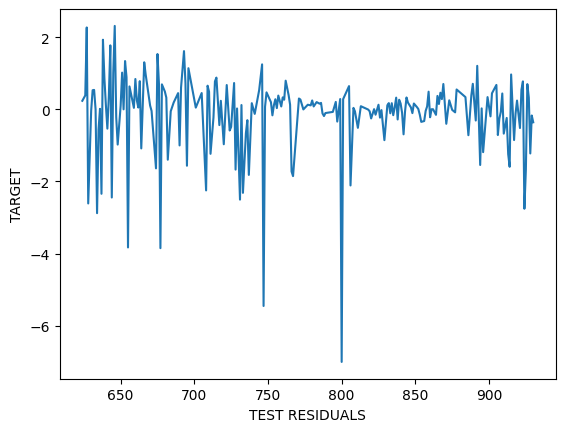

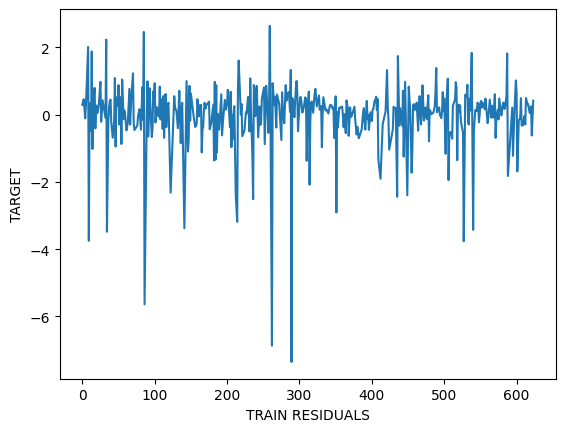

In [36]:
mlpr = MLPRegressor(alpha=0.01, solver='lbfgs', hidden_layer_sizes=(50, 20))
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, gamma=25)
train_result, test_result = test_model(mlpr, x_train, x_test, y_train, y_test, model_1=xgb_model, detailed=True, print_output=False, graph_residuals=True)

In [37]:
kf = KFold(n_splits = 10)
kf_test_model(kf, mlpr, x, target, xgb_model)

fit on test set: -18.9%
fit on training set: 31.9%

fit on test set: 36.3%
fit on training set: 37.3%

fit on test set: 21.0%
fit on training set: 26.7%

fit on test set: 32.0%
fit on training set: 33.5%

fit on test set: 26.3%
fit on training set: 21.9%

fit on test set: 25.5%
fit on training set: 32.5%

fit on test set: 35.6%
fit on training set: 19.6%

fit on test set: 20.0%
fit on training set: 16.6%

fit on test set: 47.2%
fit on training set: 40.2%

fit on test set: 28.8%
fit on training set: 38.0%



### Submission

Make sure to change x_train and x_test to be the proper sets